# Stage 1. Challenge - Image processing

# Team 1.

- Humberto
- Al-Bashir
- Grace
- Jaden

___

# Plan

- import libraries
- load images for each drug condition
- plot one or two images to check what information is stored in each color channel
- Image processing
    - Segmentation
    - spot detection
- Data management
        - create dataframe with the following columns:
            - spot_id, x, y, z, intensity, drug_condition
- Plotting data as time course
    - plot number of spots as a function of time for each drug condition.
    - plot cell intensity a function of time for each drug condition

___

In [1]:
# Loading libraries
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations

# Loading image

In [2]:

image_dir = r"C:\Users\Humberto A. Salazar\Desktop\UQbio2024_Team1\Drug1_1000nM\rep1_FOV1.tif"
#image_dir = r"C:\Users\Humberto A. Salazar\Desktop\UQbio2024_Team1\Drug1_1000nM\rep2_FOV4.tif"
image_dir

'C:\\Users\\Humberto A. Salazar\\Desktop\\UQbio2024_Team1\\Drug1_1000nM\\rep1_FOV1.tif'

In [5]:
# Importing the image as variable img
img = imread(str(image_dir))
print(type(img))
print(img.shape) # [T, Y, X, C]

<class 'numpy.ndarray'>
(21, 650, 650, 3)


# Visualization

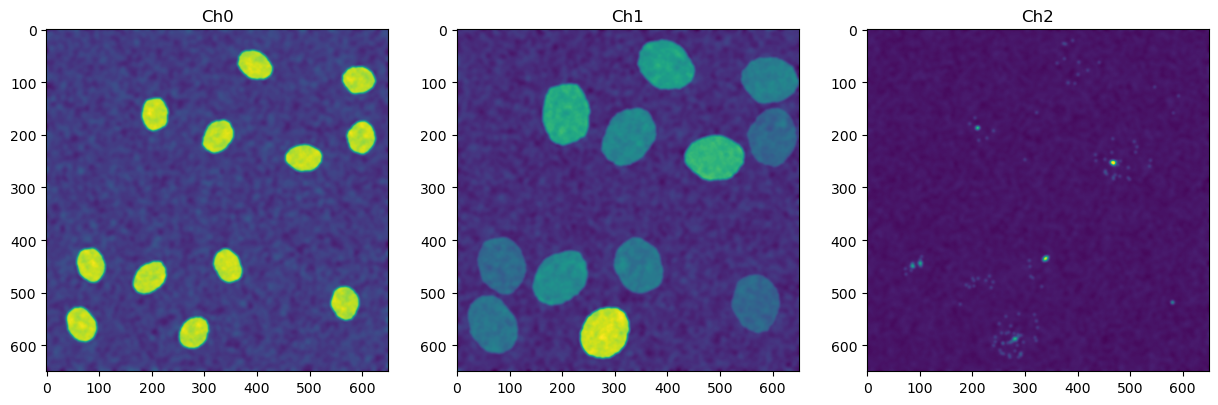

In [6]:
# Plotting all color channels at time zero.
selected_time_point =0
fig, ax = plt.subplots(1,3, figsize=(15, 5))
ax[0].imshow(img[0,:,:,0])
ax[0].set_title('Ch0')
ax[1].imshow(img[0,:,:,1])
ax[1].set_title('Ch1')
ax[2].imshow(img[0,:,:,2])
ax[2].set_title('Ch2')
plt.show()

# Segmentation
___

In [7]:
from cellpose import plot, models

## Segmentation for nucleus

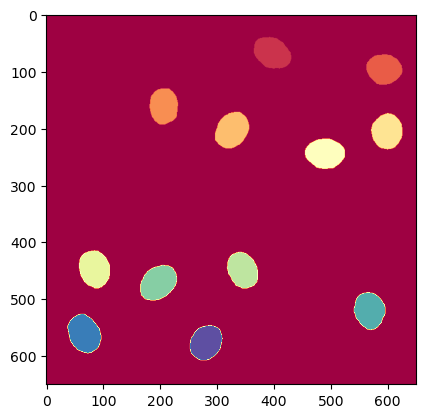

In [10]:
# Segmenting the nuclei
img_nuc = img[0,:,:,0]
model = models.Cellpose(gpu=False, model_type='nuclei') # model_type='cyto' or model_type='nuclei'
masks_nuc = model.eval(img_nuc, diameter=100, channels=[0,1])[0]
plt.imshow(masks_nuc,cmap='Spectral')
plt.show()

## Segmentation cytosol

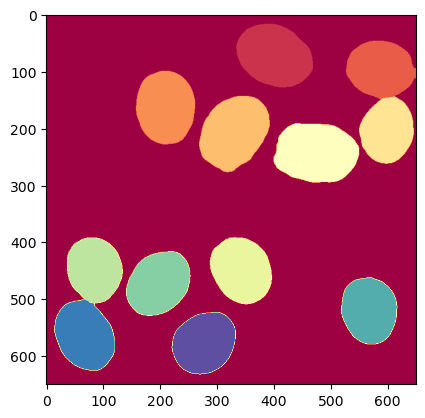

In [11]:
# Segmenting the cytosol
img_cyto = img[0,:,:,1]
model = models.Cellpose(gpu=False, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
masks_cyto = model.eval(img_cyto, diameter=200, channels=[0,2])[0]
plt.imshow(masks_cyto,cmap='Spectral')
plt.show()

In [14]:
# Associating each nucleus with its corresponding cytosol
nucleus_indices = np.zeros(np.max(masks_cyto)+1)
for i in range(1,np.max(masks_nuc)+1):
    posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
    nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i
print(nucleus_indices)

number_detected_cells= len(nucleus_indices)

[ 0.  1.  2.  3.  4.  5.  6.  8.  7.  9. 10. 11. 12.]


In [16]:
img_cyto.shape

(650, 650)

In [19]:
# Let' compute the mean intensity for each cell in the image. U
list_mean_intensities = []
selected_time =0
#for time in range(img.shape[0]) 
for iMask in range (1,number_detected_cells):
  selected_mask = masks_cyto==iMask
  mean_intensity = []
  for iColor in range(3):
    selected_color_image = selected_mask*img[selected_time, :,:,iColor]
    mean_intensity.append(selected_color_image[np.nonzero(selected_color_image)].mean())
  list_mean_intensities.append(mean_intensity)

list_mean_intensities

[[94.63104926927453, 84.14850791983898, 31.251334558501792],
 [96.99705418200946, 74.6048395581273, 30.108258811152027],
 [94.0093519124661, 98.15365192181801, 31.33021602917797],
 [93.89374428844397, 74.50294923984382, 29.89839661045111],
 [100.37040516735173, 67.69148561362302, 29.946330005871992],
 [93.19097973243612, 87.89601858527598, 33.51189617880317],
 [97.86073739344768, 71.89555304508576, 32.34846461949266],
 [102.88416102764079, 68.41552930381924, 32.63470581488703],
 [100.26104417670683, 84.7094017094017, 31.835032437442077],
 [99.40106124253813, 65.40194561131992, 29.8537475127128],
 [100.0335020242915, 71.10303643724697, 30.01751012145749],
 [98.47833014659018, 131.44837476099426, 35.37847886127045]]

In [ ]:
# Convert the list to a pandas dataframe and display
import pandas as pd
df = pd.DataFrame(list_mean_intensities, columns=['Ch0', 'Ch1', 'Ch2'])
df

In [ ]:
# Make a list of their areas.
list_cyt_areas = []
list_nuc_areas = []
for i in range (1,number_detected_cells+1):
  selected_cyto_mask = masks_cyto==i
  area_cyto = np.sum(selected_cyto_mask)
  list_cyt_areas.append(area_cyto)

  selected_nuc_mask = masks_nuc==nucleus_indices[i]
  area_nuc = np.sum(selected_nuc_mask)
  list_nuc_areas.append(area_nuc)

print(list_cyt_areas, list_nuc_areas)

# Spot detection

____

In [ ]:
import trackpy as tp

In [ ]:
# Create a function that extracts the y and x coordinates from the dataframe and
# return an extended data frame that includes a boolean true if the spot is in 
# the mask and false otherwise.
def spots_in_mask(f,mask):
    # extracting the contours in the image
    coords = np.array([f.y, f.x]).T # These are the points detected by trackpy
    coords_int = np.round(coords).astype(int)  # or np.floor, depends
    values_at_coords = mask[tuple(coords_int.T)] # If 1 the value is in the mask
    f['In Mask']=values_at_coords # Check if pts are on/in polygon mask
    return f

### select the color channel that we will be using for spot detection.

In [ ]:
video_spots = img[:,:,:,2]

In [ ]:
# This section generates an histogram with the intensity of the detected particles in the video.

particle_size = 5 # according to the documentation must be an odd number 3,5,7,9 etc.
minimal_intensity_for_selection = 0 # minimal intensity to detect a particle.

# "f" is a pandas data frame that contains the information about the detected spots
f = tp.locate(video_spots[0,:,:], particle_size, minmass=minimal_intensity_for_selection)

plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=100, color = "orangered", ec="orangered")
ax.set(xlabel='mass', ylabel='count');
ax.set_ylim([0,200])
plt.show()

In [ ]:
# tp.batch detects the spots in the image
df_TrackPy = tp.batch(video_spots[:,:,:],particle_size, minmass=25,percentile=60) # "f" is a pandas data freame that contains the infomation about the detected spots


In [ ]:
# Create a function that extracts the y and x coordinates from the dataframe and
# return an extended data frame that includes a boolean true if the spot is in 
# the mask and false otherwise.
def spots_in_mask(f,mask):
    # extracting the contours in the image
    coords = np.array([f.y, f.x]).T # These are the points detected by trackpy
    coords_int = np.round(coords).astype(int)  # or np.floor, depends
    values_at_coords = mask[tuple(coords_int.T)] # If 1 the value is in the mask
    f['In Mask']=values_at_coords # Check if pts are on/in polygon mask
    return f

In [ ]:
# add more code to select only the spots inside each cell

In [ ]:
# then link particles located inside each cell

In [ ]:
# tp.link_df is a trackpy function that links spots detected in multiple frames, this generates the spots trajectories in time.
df_linked_particles = tp.link_df(df_TrackPy,5, memory=1) # tp.link_df(data_frame, max_distance_particle_moves, max_time_particle_vanishes).

In [ ]:
#trackpy.filtering.filter_stubs(tracks, threshold=100)
df_linked_particles_filtered = tp.filter_stubs(df_linked_particles, 5)  # selecting trajectories that appear in at least 10 frames.
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', df_linked_particles['particle'].nunique())
print('After:', df_linked_particles_filtered['particle'].nunique())

In [ ]:
# Pandas data frame
df_linked_particles_filtered
